# Variational Inference

#### How to measure the similarity between two distiributions?
* Kullback-Leibler divergence
* KL divergence = variational energy + evidence = -ELBO + evidence ≥ 0
* variational inference minimize KL divergence or variational energy, or maximize ELBO

#### How to approximate the posterior?
* mean field approximation
* designate the variational distribution
* Stochastic Variational Inference etc...

#### How to calculate the variational parameters?
* variational EM algorithm
* calculate analytically
* coordinate ascent algorithm

## 0. Import

In [1]:
using Random
using Statistics
using Distributions
using LinearAlgebra
using SpecialFunctions
using ProgressMeter
using Plots
pyplot()

Plots.PyPlotBackend()

## 1. mean field approximation

* inference mean and precision of normal distribution

In [2]:
#ELBO
function ELBO1(μhat, λhat, αhat, βhat, X, β)
    SN = sum(X)
    SsqN = sum(X.^2)
    return (-log(λhat)/2+1/λhat/2-αhat*log(βhat)+log(gamma(αhat))-(αhat-1)*(digamma(αhat)-log(βhat))+αhat 
        + N*(digamma(αhat)-log(2*pi*βhat))/2-αhat*(SsqN-2*μhat*SN+N*μhat^2+N/λhat)/βhat/2-(μhat^2+1/λhat)/2
        + log(β)-β*αhat/βhat)
end

#variational inference : mean field approximation
function my_VI1(μhat₀, λhat₀, βhat₀, max_iter, ϵ, X, β)
    SN = sum(X)
    SsqN = sum(X.^2)
    μhat = μhat₀
    λhat = λhat₀
    αhat = N/2+1
    βhat = βhat₀
    
    #ELBO
    elbos = zeros(max_iter+1)
    elbos[1] = ELBO1(μhat, λhat, αhat, βhat, X, β)
    
    for i in 1:max_iter
        λhat = 1 + N*αhat/βhat
        μhat = SN * αhat/λhat/βhat
        βhat = β + SsqN/2 - μhat*SN + N*μhat^2/2 + N/λhat/2
        elbo = ELBO1(μhat, λhat, αhat, βhat, X, β)
        elbos[i+1] = elbo
        if abs(elbos[i+1]-elbos[i])<ϵ
            return μhat, λhat, αhat, βhat, elbos[1:i+1]
            break
        end
    end
    return μhat, λhat, αhat, βhat, elbos
end

#variational posterior sample
function post_sample1(μhat, λhat, αhat, βhat, n_samps)
    μsamps = rand(Normal(μhat, 1/√λhat), n_samps)
    λsamps = rand(Gamma(αhat, 1/βhat), n_samps)
    return μsamps, λsamps
end

#predictive distribution
function pred1(x, μsamps, λsamps)
    n_samps = length(μsamps)
    preds = zeros(n_samps)
    for i in 1:n_samps
        preds[i] = pdf(Normal(μsamps[i], 1/√λsamps[i]), x)
    end
    return mean(preds)
end

#Gibbs sampler : used for comparing the true posterior and variational posterior
function my_Gibbs1(μ₀, λ₀, n_samps, n_burnin, X, β)
    SN = sum(X)
    μsamps = zeros(n_samps)
    λsamps = zeros(n_samps)
    μsamps[1] = μ₀
    λsamps[1] = λ₀
    for i in 2:n_samps
        μsamps[i] = rand(Normal(λsamps[i-1]*SN/(λsamps[i-1]*N+1), 1/√(λsamps[i-1]*N+1)))
        λsamps[i] = rand(Gamma(N/2+1, 1/(β+sum((X.-μsamps[i-1]).^2)/2)))
    end
    return μsamps[n_burnin:end], λsamps[n_burnin:end]
end

my_Gibbs1 (generic function with 1 method)

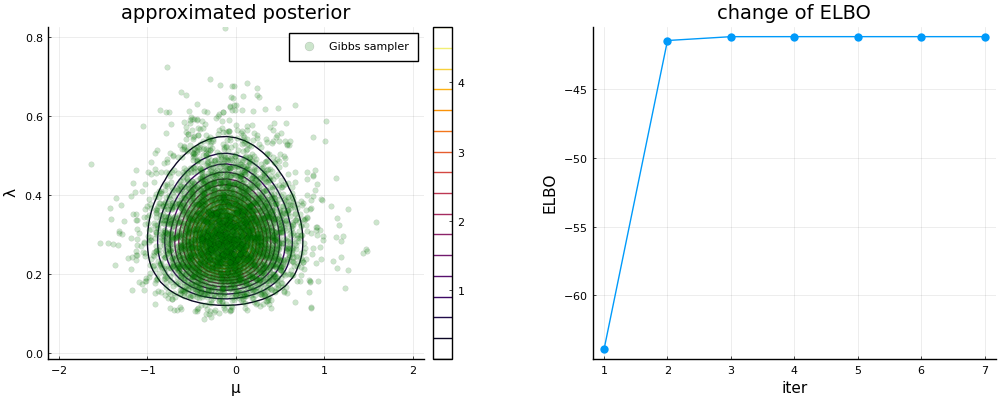

In [3]:
Random.seed!(42)

#create the data
μ₁ = -1.4
μ₂ = 1.5
σ₁ = 1.1
σ₂ = 0.9
N = 20
mixture_normal = MixtureModel([Normal(μ₁, σ₁), Normal(μ₂, σ₂)])
mixture_normal_pdf(x) = pdf(mixture_normal, x)
X = rand(mixture_normal, N)

#infernce 
β = 1e1
μhat₀ = 0.0
λhat₀ = 1.0
βhat₀ = β
max_iter = 1000
ϵ = 1e-6
μhat, λhat, αhat, βhat, elbos = my_VI1(μhat₀, λhat₀, βhat₀, max_iter, ϵ, X, β)

#approximated posterior distribution
r(μ, λ, μhat, λhat, αhat, βhat) = pdf(Normal(μhat, 1/√λhat), μ) * pdf(Gamma(αhat, 1/βhat), λ)
r(μ, λ) = r(μ, λ, μhat, λhat, αhat, βhat)

#Gibbs sampler : true posterior
μ₀ = 0.0
λ₀ = 1.0
n_samps = 5000
n_burnin = div(n_samps, 10)
μsamps, λsamps = my_Gibbs1(μ₀, λ₀, n_samps, n_burnin, X, β)

#plot the posterior
p1 = plot(-2:0.1:2, 0.01:0.01:0.8, r, st=:contour, xlabel="μ", ylabel="λ", title="approximated posterior", xlim=[-2,2], ylim=[0.01, 0.8])
plot!(μsamps, λsamps, st=:scatter, alpha=0.2, label="Gibbs sampler", markerstrokewidth=0.2, color=:green)
p2 = plot(elbos, title="change of ELBO", xlabel="iter", ylabel="ELBO", label=false, marker=:circle, markerstrokewidth=0, markersize=6)
fig1 = plot(p1, p2, size=(1000, 400))
#savefig(fig1, "figs-VI/fig1.png")

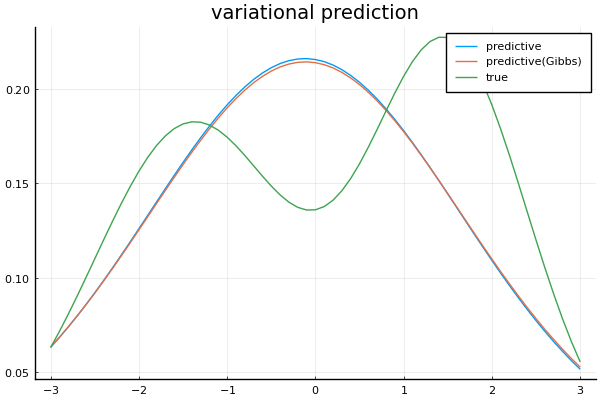

In [4]:
#variational prediction
n_samps = 5000
μsamps_var, λsamps_var = post_sample1(μhat, λhat, αhat, βhat, n_samps)
pred1_var(x) = pred1(x, μsamps_var, λsamps_var)

#true predictive distribution 
pred1(x) = pred1(x, μsamps, λsamps)

#plot
xs = -3:0.1:3
fig2 = plot(xs, pred1_var, title="variational prediction", label="predictive")
plot!(xs, pred1, label="predictive(Gibbs)")
plot!(xs, mixture_normal_pdf, label="true")
#savefig(fig2, "figs-VI/fig2.png")

## 2. designate the variational distirbution a priori

* classification using Bayesian Neural Network

In [5]:
#initialize the parameter
function init_params(Dx, D₀, Dy)
    W₂ = rand(D₀, Dx)
    W₃ = rand(Dy, D₀)
    b₂ = zeros(D₀)
    b₃ = zeros(Dy)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(params_vec, Dx, D₀, Dy)
    W = reshape(params_vec, (Dx+Dy+1, D₀+1))
    W₂ = view(W, 2:Dx+1, 1:D₀)'
    W₃ = view(W, Dx+2:Dx+Dy+1, 1:D₀)
    b₂ = view(W, 1, 1:D₀)
    b₃ = view(W, Dx+2:Dx+Dy+1, D₀+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ)) 

#Neural Network
function Φ(x, params_vec, Dx, D₀, Dy)
    W₂, W₃, b₂, b₃ = reshape_params(params_vec, Dx, D₀, Dy)
    return σ.(W₃*σ.(W₂*x+b₂) + b₃)
end

#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[1,k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[1,k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#plot the probability to classify new data to class 1(red point)
function plot_prob_1(X, Y, pred_func, title)
    T = 50
    X1s = range(0,1,length=T)
    X2s = range(0,1,length=T)
    preds = zeros(T,T)
    @showprogress for j in 1:T
        x2 = X2s[j]
        for i in 1:T
            x1 = X1s[i]
            preds[i,j] = pred_func([x1,x2])
        end
    end
    fig = heatmap(X1s, X2s, preds, c=cgrad(:coolwarm), alpha=0.6, title=title)
    return plot_data(fig, X, Y)
end

#prior for each element
prior_dist(λw) = Normal(0, 1/√λw)
logpprior(w, λw) = logpdf(prior_dist(λw), w)
pprior(w, λw) = exp(logpprior(w, λw))

#model
logpmodel(y, x, wvec, Φ) = log(dot(y, Φ(x,wvec))/sum(Φ(x,wvec)))
pmodel(y, x, wvec, Φ) = exp(logpmodel(y, x, wvec, Φ))

#liklihood
loglik(wvec, Φ, X, Y, N) = sum([logpmodel(Y[:,n], X[:,n], wvec, Φ) for n in 1:N])

#posterior
logppost(wvec, λw, Φ, X, Y, N) = sum(logpprior(wvec,λw)) + loglik(wvec, Φ, X, Y, N)
ppost(wvec, λw, Φ, X, Y, N) = exp(logppost(wvec, λw, Φ, X, Y, N))

#predictive: returns the probability to new data classify to class 1
function ppred(x, wsamps, pmodel)
    _,n_samps = size(wsamps)
    preds = zeros(n_samps)
    for i in 1:n_samps
        preds[i] = pmodel([1,0], x, wsamps[:,i])
    end
    return mean(preds)
end

#∇logr
function ∇logr(wvec, params)
    d = length(wvec)
    μs = params[1:d]
    λs = params[d+1:end]
    ∇μs = λs .* (wvec - μs)
    ∇λs = (1 ./λs - (wvec - μs).^2)/2
    return vcat(∇μs, ∇λs)
end

#function : Er[f]
f(x, y, params, wvec, logpmodel) = logpmodel(y, x, wvec) * ∇logr(wvec, params)

#sample func
function sample_from_r(params)
    d = div(length(params), 2)
    samp = zeros(d)
    for j in 1:d
        μj = params[j]
        λj = params[d+j]
        samp[j] = rand(Normal(μj, 1/√λj))
    end
    return samp
end
    
#MC approximation : expectation with respect to r(w)
function Er(x, y, params, n_samps, f)
    d = div(length(params), 2)
    Esamps = zeros(2*d, n_samps)
    samp = zeros(d)
    for i in 1:n_samps
        samp = sample_from_r(params)
        Esamps[:,i] = f(x, y, params, samp, logpmodel)
    end
    return mean(Esamps, dims=2)
end

#gradient Kullback-Leibler divergence with respect to variational parameter
function ∇DKL(params, λw)
    d = div(length(params), 2)
    μs = params[1:d]
    λs = params[d+1:end]
    ∇μDKL = λw * μs
    ∇λDKL = (1 ./λs - λw./λs.^2)/2
    return vcat(∇μDKL, ∇λDKL)
end

#∇ELBO
∇ELBO(x, y, params, n_samps, λw) = Er(x, y, params, n_samps, f) - ∇DKL(params, λw)

#variational infernce
function myVI(X, Y, λw, n_train, n_samps, d, ϵ)
    _, N = size(X)
    params = vcat(zeros(d), ones(d))
    @showprogress for k in 1:n_train
        idx = rand(1:N)
        x = X[:,idx]
        y = Y[:,idx]
        params += ϵ  * N * ∇ELBO(x, y, params, n_samps, λw) / k
    end
    return params
end

#sample from posterior
function sample_from_posterior(params, n_samps)
    d = div(length(params), 2)
    wsamps = zeros(d, n_samps)
    for j in 1:d
        μj = params[j]
        λj = params[d+j]
        wsamps[j,:] = rand(Normal(μj, 1/√λj), n_samps)
    end
    return wsamps
end

#calculate WAIC
function calc_WAIC(X, Y, wsamps, pmodel, logpmodel)
    _,N = size(X)
    _,n_samps = size(wsamps)
    logpreds = zeros(N)
    vars = zeros(N)
    for n in 1:N
        logpreds[n] = -log(mean([pmodel(Y[:,n], X[:,n], wsamps[:,i]) for i in 1:n_samps]))
        vars[n] = var([logpmodel(Y[:,n], X[:,n], wsamps[:,i]) for i in 1:n_samps])
    end
    return mean(logpreds) + mean(vars)
end

#model selection
function model_selection(X, Y, λws, n_samps, ϵ, pmodel, logpmodel)
    n_train = 1000
    M = length(λws)
    WAICs = zeros(M)
    for i in 1:M
        params = myVI(X, Y, λws[i], n_train, n_samps, d, ϵ)    
        wsamps = sample_from_posterior(params, n_samps)
        WAICs[i] = calc_WAIC(X, Y, wsamps, pmodel, logpmodel)
    end
    return WAICs
end

model_selection (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


λw=99.99999999999999 minimize WAIC (std=0.1). 


Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


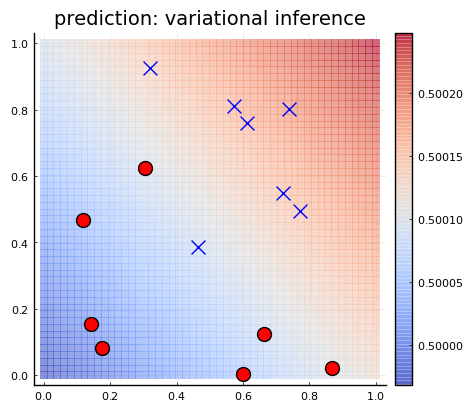

In [6]:
#create the data
Random.seed!(46)
N = 14
X = hcat(rand(Beta(1.1,3), 2, div(N,2)), rand(Beta(1.9,1.1), 2, div(N,2)))
Y = vcat(vcat(ones(div(N,2)), zeros(div(N,2)))', vcat(zeros(div(N,2)), ones(div(N,2)))')

#plot the data
fig3 = plot_data(X, Y)
savefig(fig3, "figs-VI/fig3.png")

#initialize the parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ = 5
W₂, W₃, b₂, b₃ = init_params(Dx, D₀, Dy)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]
d = length(wvec₀)

#Neural Network 
Φ(x, wvec) = Φ(x, wvec, Dx, D₀, Dy) 

#model, posterior, predictive
logpmodel(y, x, wvec) = logpmodel(y, x, wvec, Φ)
pmodel(y,x,wvec) = exp(logpmodel(y, x, wvec))
ppred(x, wsamps) = ppred(x, wsamps, pmodel)

#model selection
ϵ = 0.01
λws = 1 ./ collect(0.1:0.1:1.0) .^2
WAICs = model_selection(X, Y, λws, 5000, ϵ, pmodel, logpmodel)
λw = λws[argmin(WAICs)]
println("λw=$(λw) minimize WAIC (std=$(1/sqrt(λw))). ")

#calculate the variational parameters
n_train = 1000
n_samps = 5000
params = myVI(X, Y, λw, n_train, n_samps, d, ϵ)

#posterior sample
wsamps = sample_from_posterior(params, n_samps)

#plot the result
fig4 = plot_prob_1(X, Y, x->ppred(x, wsamps), "prediction: variational inference")
savefig(fig4, "figs-VI/fig4.png")